# Project Overview

This project aims to predict house sale prices using machine learning models. We utilize the Kaggle House Prices dataset, performing data preprocessing, feature engineering, model selection, hyperparameter tuning, and evaluation to achieve the best predictive performance.

Dataset Source: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

Author: Jiaxin Liu



In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew, norm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

In [20]:
# Function to load training and test data
def load_data(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    return train, test

# Load the data
train, test = load_data("train.csv", "test.csv")

# Display the shape of the datasets
print("Training set shape:", train.shape)
print("Test set shape:", test.shape)


Training set shape: (1460, 81)
Test set shape: (1459, 80)


In [21]:
# Display the first few rows of the training data
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Preprocessing and Feature Engineering
#### Handling Missing Values

In [23]:
def handle_missing(features):
    """
    Handles missing values in the dataset by filling them with appropriate statistics or placeholders.
    """
    # Fill missing values based on data description
    features['Functional'] = features['Functional'].fillna('Typ')
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

    # Pool Quality: NA means no pool
    features["PoolQC"] = features["PoolQC"].fillna("None")

    # Garage: NA means no garage
    for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
        features[col] = features[col].fillna(0)

    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')

    # Basement: NA means no basement
    for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
        features[col] = features[col].fillna('None')
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # Fill remaining categorical features with 'None'
    categorical_cols = features.select_dtypes(include=['object']).columns
    features[categorical_cols] = features[categorical_cols].fillna('None')
    numerical_cols = features.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns
    features[numerical_cols] = features[numerical_cols].fillna(0)

    return features


#### Feature Transformation

In [24]:
# Concatenate train and test data for consistent preprocessing
all_data = pd.concat([train.drop('SalePrice', axis=1), test], sort=False).reset_index(drop=True)

# Handle missing values
all_data = handle_missing(all_data)

#### Encoding Categorical Variables

In [25]:
# Convert categorical variables to dummy/indicator variables
all_data = pd.get_dummies(all_data).reset_index(drop=True)

# Remove any duplicated columns
all_data = all_data.loc[:, ~all_data.columns.duplicated()]


#### Log Transformation of Target Variable

In [26]:
# Log-transform the target variable to reduce skewness
train["SalePrice"] = np.log1p(train["SalePrice"])


#### Splitting the Data

In [29]:
def preprocess_data(train, test, test_ratio=0.10):
    """
    Preprocess the data by handling missing values, encoding categorical variables,
    and splitting into training and validation sets.
    """
    # Log-transform the target variable
    train["SalePrice"] = np.log1p(train["SalePrice"])

    # Split the training data into train and validation sets
    train_split, val_split = train_test_split(train, test_size=test_ratio, random_state=42)

    # Separate features and target
    train_labels = train_split['SalePrice'].reset_index(drop=True)
    train_features = train_split.drop(['SalePrice'], axis=1)

    val_labels = val_split['SalePrice'].reset_index(drop=True)
    val_features = val_split.drop(['SalePrice'], axis=1)

    test_features = test

    all_features = pd.concat([train_features, test_features, val_features]).reset_index(drop=True)
    all_features = handle_missing(all_features)
    all_features = pd.get_dummies(all_features).reset_index(drop=True)
    all_features = all_features.loc[:, ~all_features.columns.duplicated()]

    # Split the features back into train, validation, and test sets
    TRAIN_COUNT = len(train_features)
    TEST_COUNT = len(test_features)
    VAL_COUNT = len(val_features)
    train_features = all_features.iloc[:TRAIN_COUNT, :]
    test_features = all_features.iloc[TRAIN_COUNT:TRAIN_COUNT+TEST_COUNT, :]
    val_features = all_features.iloc[TRAIN_COUNT+TEST_COUNT:TRAIN_COUNT+TEST_COUNT+VAL_COUNT, :]

    return train_features, train_labels, val_features, val_labels, test_features

train_features, train_labels, val_features, val_labels, test_features = preprocess_data(train, test)


## Model Selection and Hyperparameter Tuning
#### Random Forest Regressor

In [30]:
# Define hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param_grid,
                       cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the model
rf_grid.fit(train_features, train_labels)

# Best parameters and score
print("Random Forest Best Parameters:", rf_grid.best_params_)
print("Random Forest Best RMSE:", np.sqrt(-rf_grid.best_score_))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Random Forest Best Parameters: {'max_depth': 20, 'n_estimators': 300}
Random Forest Best RMSE: 0.011217130829907211


#### Ridge Regression

In [31]:
# Define hyperparameter grid for Ridge Regression
ridge_param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0]
}

# Initialize Ridge Regression
ridge = Ridge(random_state=42)

# Initialize GridSearchCV
ridge_grid = GridSearchCV(estimator=ridge, param_grid=ridge_param_grid,
                          cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the model
ridge_grid.fit(train_features, train_labels)

# Best parameters and score
print("Ridge Regression Best Parameters:", ridge_grid.best_params_)
print("Ridge Regression Best RMSE:", np.sqrt(-ridge_grid.best_score_))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Ridge Regression Best Parameters: {'alpha': 10.0}
Ridge Regression Best RMSE: 0.011389442064996945


#### Gradient Boosting Regressor


In [32]:
# Define hyperparameter grid for Gradient Boosting Regressor
gbr_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 4, 5]
}

# Initialize Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Initialize GridSearchCV
gbr_grid = GridSearchCV(estimator=gbr, param_grid=gbr_param_grid,
                        cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the model
gbr_grid.fit(train_features, train_labels)

# Best parameters and score
print("Gradient Boosting Regressor Best Parameters:", gbr_grid.best_params_)
print("Gradient Boosting Regressor Best RMSE:", np.sqrt(-gbr_grid.best_score_))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Gradient Boosting Regressor Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Gradient Boosting Regressor Best RMSE: 0.010250006223359306


## Model Evaluation and Selection
#### Extract Best Estimators

In [33]:
# Extract the best models from GridSearchCV
best_rf = rf_grid.best_estimator_
best_ridge = ridge_grid.best_estimator_
best_gbr = gbr_grid.best_estimator_


In [34]:
def evaluate_model(model, X_val, y_val):
    """
    Evaluates the model on validation data and returns RMSE and MAE.
    """
    predictions = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    mae = mean_absolute_error(y_val, predictions)
    return rmse, mae


#### Evaluate Each Model

In [37]:
# Evaluate Random Forest
rf_rmse, rf_mae = evaluate_model(best_rf, val_features, val_labels)
print(f"Random Forest - RMSE: {rf_rmse}, MAE: {rf_mae}")

# Evaluate Ridge Regression
ridge_rmse, ridge_mae = evaluate_model(best_ridge, val_features, val_labels)
print(f"Ridge Regression - RMSE: {ridge_rmse}, MAE: {ridge_mae}")

# Evaluate Gradient Boosting Regressor
gbr_rmse, gbr_mae = evaluate_model(best_gbr, val_features, val_labels)
print(f"Gradient Boosting Regressor - RMSE: {gbr_rmse}, MAE: {gbr_mae}")


Random Forest - RMSE: 0.01018936699644481, MAE: 0.0067609015567355515
Ridge Regression - RMSE: 0.009130553662341254, MAE: 0.0066119759085709
Gradient Boosting Regressor - RMSE: 0.008653730489175688, MAE: 0.0057592131498410285


In [59]:
# Create a dataframe for performance comparison
performance = pd.DataFrame({
    'Model': ['Random Forest', 'Ridge Regression', 'Gradient Boosting'],
    'RMSE': [rf_rmse, ridge_rmse, gbr_rmse],
    'MAE': [rf_mae, ridge_mae, gbr_mae]
})

performance

,Model,RMSE,MAE
0,Random Forest,0.010189,0.006761
1,Ridge Regression,0.009131,0.006612
2,Gradient Boosting,0.008654,0.005759


<ipython-input-39-14d10f912e6e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=performance, palette='viridis')


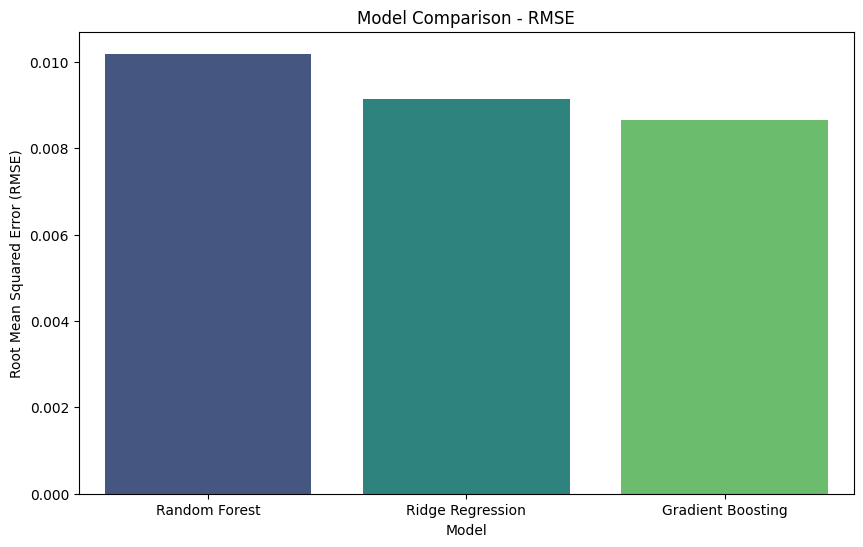

In [39]:
# Plot RMSE Comparison
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='RMSE', data=performance, palette='viridis')
plt.title('Model Comparison - RMSE')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.show()


<ipython-input-40-79dea52a3d92>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=performance, palette='magma')


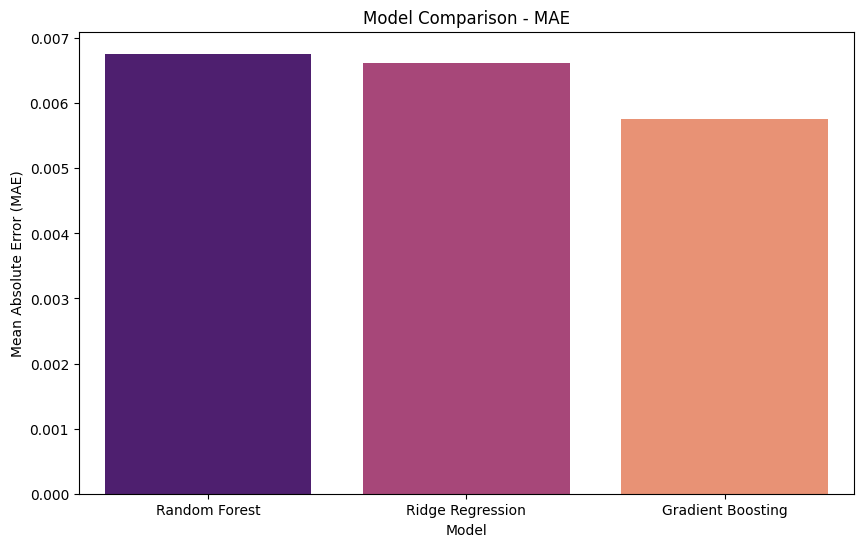

In [40]:
# Plot MAE Comparison
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='MAE', data=performance, palette='magma')
plt.title('Model Comparison - MAE')
plt.ylabel('Mean Absolute Error (MAE)')
plt.show()


## Final Model Training and Prediction
#### Combine Training and Validation Sets

In [41]:
# Combine training and validation sets for final training
full_train_features = pd.concat([train_features, val_features], axis=0)
full_train_labels = pd.concat([train_labels, val_labels], axis=0)


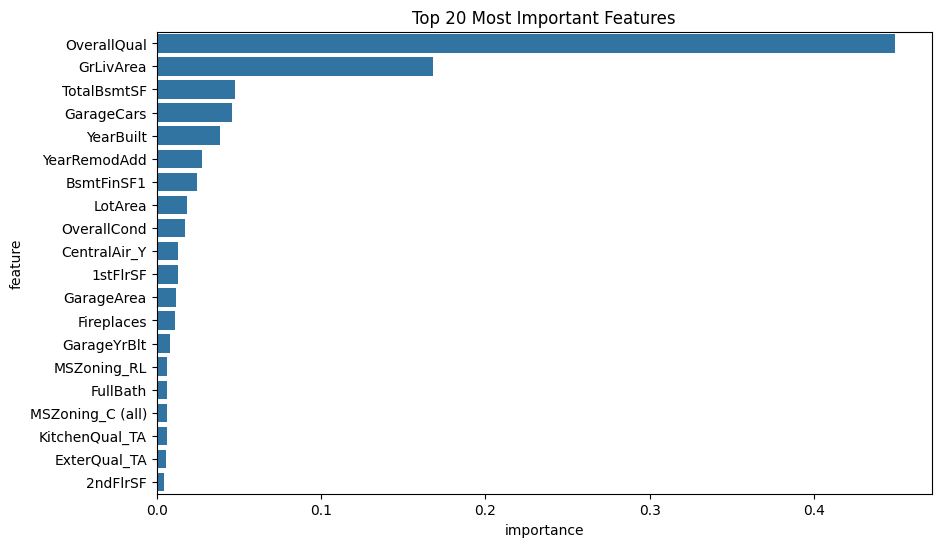

In [58]:
# Initialize the final model (choose the best performing model)
final_model = best_gbr

# Train the final model on the full training data
final_model.fit(full_train_features, full_train_labels)

# get feature importance
importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': full_train_features.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

# top 20 important features
plt.figure(figsize=(10,6))
sns.barplot(data=feature_importance_df.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important Features')
plt.show()

In [57]:
# Cross validation RMSE
cv_scores = cross_val_score(final_model,
                          full_train_features,
                          full_train_labels,
                          cv=5,
                          scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-cv_scores)
print(f"Cross-validation RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std()*2:.4f})")

Cross-validation RMSE: 0.0098 (+/- 0.0023)


#### Predict on Test Data

In [56]:
# Make predictions on the test set
test_predictions = np.floor(np.expm1(final_model.predict(test_features)))

# Load sample submission
submission = pd.read_csv("sample_submission.csv")

# Assign predictions to the 'SalePrice' column
submission['SalePrice'] = test_predictions

# Save predicted results to the result file
submission.to_csv("result.csv", index=False)
print("Result file 'result.csv' has been created.")


Result file 'result.csv' has been created.


## Stretch Goals: Innovation and Model Blending
#### Model Blending

In [62]:
def predict_blended(models, test_features):
    """
    Blends predictions from multiple models with specified weights.
    """
    rf, ridge, gbr = models
    blended_predictions = (0.25 * rf.predict(test_features) +
                           0.25 * ridge.predict(test_features) +
                           0.5 * gbr.predict(test_features))
    return blended_predictions

# Retrain models on full data
final_rf = best_rf.fit(full_train_features, full_train_labels)
final_ridge = best_ridge.fit(full_train_features, full_train_labels)
final_gbr = best_gbr.fit(full_train_features, full_train_labels)

# Blended predictions
blended_predictions = np.floor(np.expm1(predict_blended([final_rf, final_ridge, final_gbr], test_features)))

blended_result = pd.read_csv("sample_submission.csv")
blended_result['SalePrice'] = blended_predictions
blended_result.to_csv("blended_result.csv", index=False)
print("Blended submission file 'blended_result.csv' has been created.")


Blended Model RMSE on Validation Set: 0.00433952512537079
Blended submission file 'blended_result.csv' has been created.


#### Evaluate Each Model

In [77]:
# Evaluate Random Forest
final_rf_rmse, final_rf_mae = evaluate_model(final_rf, val_features, val_labels)
print(f"Final Random Forest - RMSE: {final_rf_rmse}, MAE: {final_rf_mae}")

# Evaluate Ridge Regression
final_ridge_rmse, final_ridge_mae = evaluate_model(final_ridge, val_features, val_labels)
print(f"Final Ridge Regression - RMSE: {final_ridge_rmse}, MAE: {final_ridge_mae}")

# Evaluate Gradient Boosting Regressor
final_gbr_rmse, final_gbr_mae = evaluate_model(final_gbr, val_features, val_labels)
print(f"Final Gradient Boosting Regressor - RMSE: {final_gbr_rmse}, MAE: {final_gbr_rmse}")


Final Random Forest - RMSE: 0.0037907662648051788, MAE: 0.0025941507421428536
Final Ridge Regression - RMSE: 0.007842088524827828, MAE: 0.005779155315332002
Final Gradient Boosting Regressor - RMSE: 0.0039043225676571253, MAE: 0.0039043225676571253


<ipython-input-74-18a9d5396d7e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=final_performance, palette='viridis')


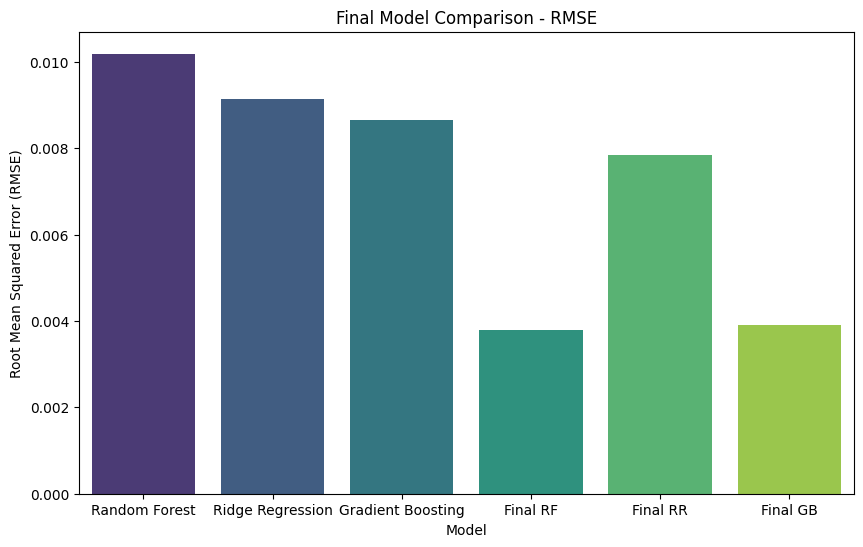

In [74]:
# Create a dataframe for performance comparison
final_performance = pd.DataFrame({
    'Model': ['Random Forest', 'Ridge Regression', 'Gradient Boosting', 'Final RF', 'Final RR', 'Final GB'],
    'RMSE': [rf_rmse, ridge_rmse, gbr_rmse, final_rf_rmse, final_ridge_rmse, final_gbr_rmse],
    'MAE': [rf_rmse, ridge_mae, gbr_mae, final_rf_mae, final_ridge_mae, final_gbr_mae]
})

plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='RMSE', data=final_performance, palette='viridis')
plt.title('Final Model Comparison - RMSE')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.show()

<ipython-input-73-1ca7156101d9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=final_performance, palette='magma')


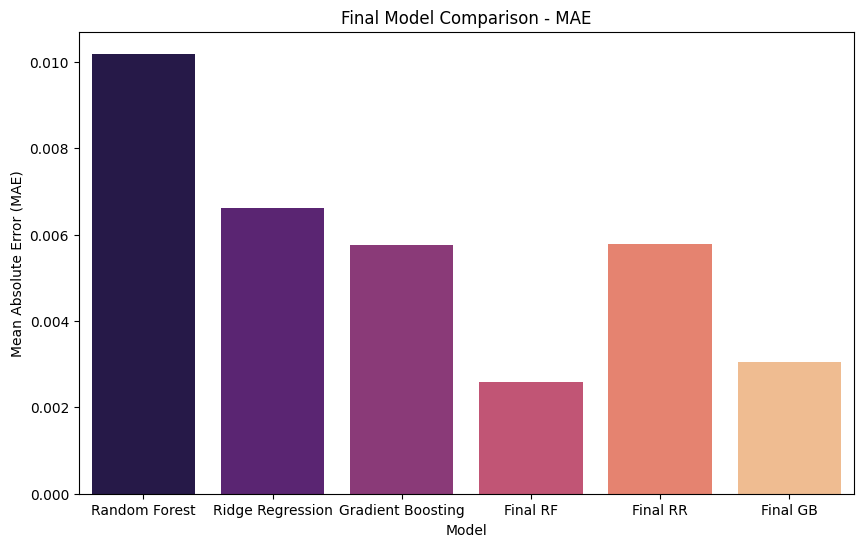

In [73]:
# Plot MAE Comparison
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='MAE', data=final_performance, palette='magma')
plt.title('Final Model Comparison - MAE')
plt.ylabel('Mean Absolute Error (MAE)')
plt.show()